In [63]:
import tensorflow as tf
from tensorflow.keras.models import load_model

from PIL import Image as PILImage

import cv2
import numpy as np
import glob
import os

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import Sequence

from keras.layers import Layer

import csv
import pandas as pd

from annoy import AnnoyIndex

In [64]:
IMAGE_SIZE = (256, 256)

In [65]:
def imshow(a, size=1.0):
    # Clip and convert the image to uint8
    a = a.clip(0, 255).astype("uint8")
    
    # Resize the image if a size factor is provided
    if size != 1.0:
        new_dim = (int(a.shape[1] * size), int(a.shape[0] * size))
        a = cv2.resize(a, new_dim, interpolation=cv2.INTER_AREA)
    
    # Display the image
    display(PILImage.fromarray(a))

In [66]:
data_folder = "Data/00*"
image_files = glob.glob(os.path.join(data_folder, "*.jpg"), recursive=True)

In [67]:
class L2Normalization(Layer):
    def call(self, inputs):
        return tf.math.l2_normalize(inputs, axis=1)

In [68]:
model = load_model("Models/embedding_extractor_custom.keras",
    custom_objects={"L2Normalization": L2Normalization})

In [69]:
def read_image(file_path):
    img = cv2.imread(file_path)
    img = cv2.resize(img, IMAGE_SIZE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


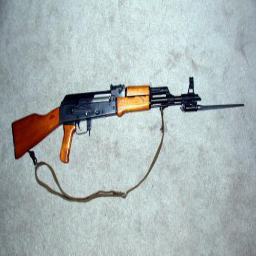

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


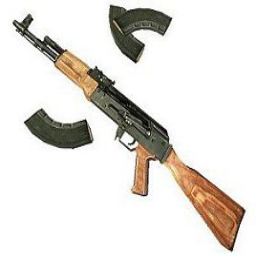

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


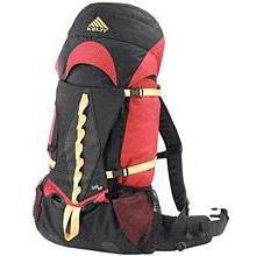

Distance between image 1 and image 2: 0.06150686
Distance between image 1 and image 3: 0.32555184


In [70]:
import tensorflow as tf

img_1 = read_image(image_files[0])
emb_1 = model.predict(np.expand_dims(img_1, axis=0), verbose=1)
imshow(img_1)

img_2 = read_image(image_files[1])
emb_2 = model.predict(np.expand_dims(img_2, axis=0), verbose=1)
imshow(img_2)

img_3 = read_image(image_files[342])
emb_3 = model.predict(np.expand_dims(img_3, axis=0), verbose=1)
imshow(img_3)

dist_1_2 = np.linalg.norm(emb_1 - emb_2)
dist_1_3 = np.linalg.norm(emb_1 - emb_3)

print("Distance between image 1 and image 2:", dist_1_2)
print("Distance between image 1 and image 3:", dist_1_3)

In [71]:
#GENERATE EMBEDDINGS FOR ALL IMAGES AND STORE AS ANNOY FIEL FOR QUCIK SEARCH

embedding_dimensions = 512
index = AnnoyIndex(embedding_dimensions, "angular")  # Use "angular" or "euclidean" as needed
embeddings=[]

# Embedding extraction loop
for i, file_path in enumerate(image_files):
    img = read_image(file_path)
    emb = model.predict(np.expand_dims(img, axis=0), verbose=0)[0]
    emb = np.array(emb)
    embeddings.append(emb)
    
    # Add the embedding to the Annoy index
    index.add_item(i, emb)
    
    if (i + 1) % 500 == 0:
        print(f"Processed {i + 1} of {len(image_files)}")

# Build the index (You can change the number of trees to optimize for memory/speed)
index.build(10)

# Save the Annoy index to a file
index_file = "Annoys/custom_extractor.ann"
index.save(index_file)

print(f"Annoy index saved to {index_file}")

Processed 500 of 1151
Processed 1000 of 1151
Annoy index saved to Annoys/custom_extractor.ann


In [72]:
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

In [73]:
def get_label(file_path):
    label = file_path.split("/")[-2]
    label = label.split(".")[-2]
    label = int(label)
    return label

labels = [get_label(file_path) for file_path in image_files]

In [74]:

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

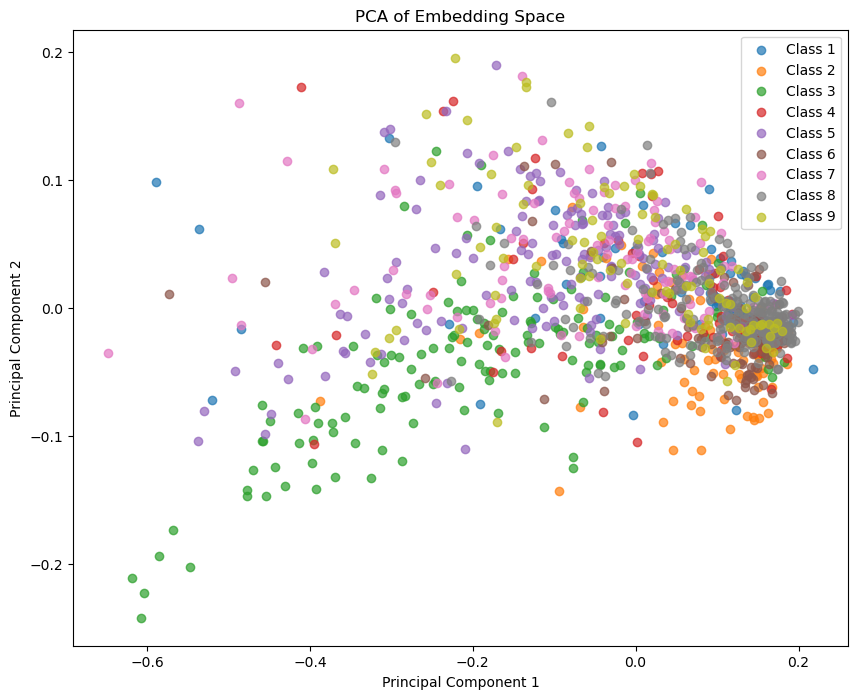

In [75]:
def plot_embeddings(embeddings, labels):
    plt.figure(figsize=(10, 8))
    for label in set(labels):
        indices = [i for i, lbl in enumerate(labels) if lbl == label]
        plt.scatter(
            embeddings[indices, 0], 
            embeddings[indices, 1], 
            label=f"Class {label}", 
            alpha=0.7
        )
    plt.legend()
    plt.title("PCA of Embedding Space")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()

# Plot the reduced embeddings
plot_embeddings(reduced_embeddings, labels)